#### NCSU GIS 714: Geospatial Computation and Simulations

## Spatio-temporal data handling and visualization in GRASS GIS: Part 2

Contents:
* Terrain time series visualization: process Nags Head coastal terrain time series and visualize space-time cube

Additional Resources:
* [GRASS GIS Overview and Manual](https://grass.osgeo.org/grass-stable/manuals/index.html)
* [GRASS book](http://www.grassbook.org/)

## Terrain time series visualization

### Start GRASS GIS
Start grass7 with location NC_spm_temporal_workshop and mapset NagsHead_series.

In [1]:
# import subprocess
import sys

"""
# Ask GRASS GIS where its Python packages are.
# FOR WINDOWS:
# grass_call = "grass80"
# shell_setting = True
# FOR MAC/LINUX
grass_call = "grass"
shell_setting = False

sys.path.append(
    subprocess.check_output([grass_call, "--config", "python_path"], text=True, shell=shell_setting).strip()
)
"""
# Configuration on my laptop
sys.path.append('/Applications/GRASS-8.4.app/Contents/Resources/etc/python')

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
gj.init("../data", "NC_spm_temporal_workshop", "NagsHead_series")

### Time series registration and visualization
First, we create an empty space-time raster dataset. We will use relative time with years as units.

In [2]:
gs.run_command('t.create', output='NagsHead_99_08', type='strds',
                temporaltype='relative', title="Nags Head elevation series",
                description="from 1999 to 2008 with gaps")

Register maps in the dataset using the list of maps bellow. Each map has an associated year, stored in the NH.txt file. Open the file and check out the contents. 

In [3]:
gs.run_command("t.register", input="NagsHead_99_08", type="raster", file="./NH.txt", unit="years")

Since there are gaps in the dataset, we decided to interpolate missing data. The interpolated maps are already in the mapset so we will skip this step now. (The maps were linearly interpolated with [r.series.interp](https://grass.osgeo.org/grass80/manuals/r.series.interp.html). For interval data, you could use [t.rast.gapfill](https://grass.osgeo.org/grass80/manuals/t.rast.gapfill.html).

We still have to register interpolated maps to the existing dataset.

In [4]:
gs.run_command("t.register", input="NagsHead_99_08", file="./interp.txt", unit="years")

Check what you have now in NagsHead_99_08 dataset.

In [5]:
print(gs.read_command("t.rast.list", input="NagsHead_99_08"))

name|mapset|start_time|end_time
NH_1999_1m|NagsHead_series|1999|None
NH_2000_1m_interp|NagsHead_series|2000|None
NH_2001_1m|NagsHead_series|2001|None
NH_2002_1m_interp|NagsHead_series|2002|None
NH_2003_1m_interp|NagsHead_series|2003|None
NH_2004_1m|NagsHead_series|2004|None
NH_2005_1m|NagsHead_series|2005|None
NH_2006_1m_interp|NagsHead_series|2006|None
NH_2007_1m|NagsHead_series|2007|None
NH_2008_1m|NagsHead_series|2008|None



Set the same color table for all maps (copy the color table from map NH_1999_1m).

In [6]:
gs.run_command("t.rast.colors", input="NagsHead_99_08", raster="NH_1999_1m")

Display animation of space-time raster data set NagsHead_99_08

In [7]:
nh_animation = gj.TimeSeriesMap()
nh_animation.add_raster_series("NagsHead_99_08")
nh_animation.d_legend(color="black", at=(12,72,0,3), fontsize=12)
nh_animation.d_barscale(length=250)
nh_animation.show()

### Space-time cube representation

Space-time cube is 3-dimensional representation where z-coordinate is time. We use 3D raster to represent space-time cube with z-coordinates as values of the 3D raster to explore the evolution of terrain in time [1, 2, 3].

To create space-time cube we vertically stack the series of digital elevation models using t.rast.to.rast3:

In [8]:
# convert strds to 3D raster
gs.run_command("t.rast.to.rast3", input="NagsHead_99_08", output="NagsHead_99_08")

# check 3D extent and min and max values
print(gs.read_command("r3.info", map="NagsHead_99_08", flags="g"))

north=250670
south=249730
east=914342
west=913366
bottom=1999
top=2009
nsres=1
ewres=1
tbres=1
rows=940
cols=976
depths=10
datatype="DCELL"
timestamp="1999 years / 2008 years"
units="none"
vertical_units="years"
tilenumx=34
tilenumy=34
tilenumz=2
tiledimx=29
tiledimy=28
tiledimz=5



In [9]:
# set region to this 3D raster for further processing
gs.run_command("g.region", raster_3d="NagsHead_99_08", flags="p3")

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      250670
south:      249730
west:       913366
east:       914342
top:        2009.00000000
bottom:     1999.00000000
nsres:      1
nsres3:     1
ewres:      1
ewres3:     1
tbres:      1
rows:       940
rows3:      940
cols:       976
cols3:      976
depths:     10
cells:      917440
cells3:     9174400


Now, create a new 3D raster which will be used for coloring isosurfaces by years. Using [t.rast.mapcalc](https://grass.osgeo.org/grass80/manuals/t.rast.mapcalc.html), we create a series of single-value raster maps for each year and then we stack them into a 3D raster.

In [10]:
gs.run_command('t.rast.mapcalc', inputs='NagsHead_99_08',
                expression="start_time() + 1999", output='NagsHead_years',
                basename='NagsHead_years', nprocs='4')

gs.run_command('t.rast.to.rast3', input='NagsHead_years',
                output='NagsHead_years')

Now set the color tables of the space-time cube 3D raster and the second 3D raster.

In [11]:
gs.run_command('r3.colors', map='NagsHead_99_08', color='elevation')
gs.run_command('r3.colors', map='NagsHead_years', color='bcyr')

Set lower resolution to speed up 3D rendering.

In [12]:
gs.run_command('g.region', flags='p3', res3='3', tbres='1')

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      250670
south:      249730
west:       913366
east:       914342
top:        2009.00000000
bottom:     1999.00000000
nsres:      1
nsres3:     3.00319489
ewres:      1
ewres3:     3.00307692
tbres:      1
rows:       940
rows3:      313
cols:       976
cols3:      325
depths:     10
cells:      917440
cells3:     1017250


We use [grass.jupyter.Map3D](https://grass.osgeo.org/grass81/manuals/libpython/grass.jupyter.html#module-grass.jupyter.map3d) to create the space-time cube representation. The `render()` method passes its keyword arguements (kwargs) to [m.nviz.image](https://grass.osgeo.org/grass80/manuals/m.nviz.image.html), the 3D rendering module for GRASS GIS.

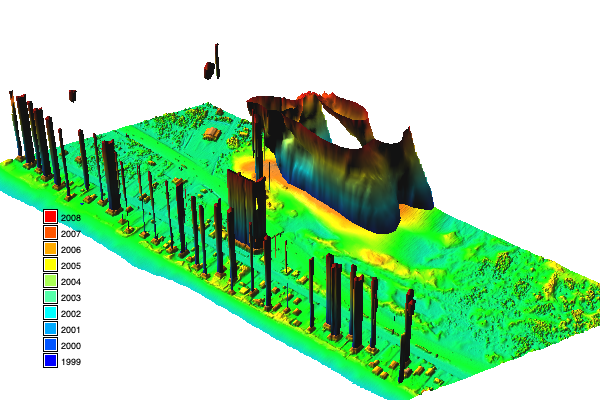

In [13]:
cube_viz = gj.Map3D(use_region=True)
cube_viz.render(elevation_map="NH_2008_1m_0.05", color_map="NH_2008_1m_0.05", volume="NagsHead_99_08", isosurf_level="1:11", isosurf_color_map="NagsHead_years", volume_resolution=1, flags="n", resolution_fine=1, height=100, zexag=20, perspective=15, position="0.7,0.1")
cube_viz.overlay.d_legend(rast3d="NagsHead_years", at=(5,50,7,10), use="1999,2000,2001,2002,2003,2004,2005,2006,2007,2008", flags="f")
cube_viz.show()

### References

[1] Mitasova, H., Harmon, R. S., Weaver, K. J., Lyons, N. J., Overton, M. F. (2012). Scientific visualization of landscapes and landforms. Geomorphology, 137(1), 122–137.

[2] Mitasova, H., Hardin, E., Starek, M. J., Harmon, R. S., Overton, M. F. (2011). Landscape dynamics from LiDAR data time series. Geomorphometry, 3–6.

[3] Starek, M.J., Mitasova H., Hardin, E., Overton, M.F., Harmon, R.S. (2011). Modeling and analysis of landscape evolution using airborne, terrestrial, and laboratory laser scanning. Geosphere, 7(6), p. 1340–1356.

### Additional Information
* [Website](https://github.com/ncsu-geoforall-lab/geospatial-simulations-course)
    
* [Computing Help](https://help.ncsu.edu/)
    
* [GIST Home](https://geospatial.ncsu.edu/)
    
* [Disclaimer](https://www.ncsu.edu/policies/prr-disclaimer.php)
    
* [Accessibility](https://oit.ncsu.edu/itaccess)

* License: 2018 [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/)
  
* [NCSU GeoForAll Lab](https://geospatial.ncsu.edu/geoforall/)